In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Dataset

In [4]:
# Dataset paths
train_dir = '../dataset/train'
val_dir = '../dataset/validation'
test_dir = '../dataset/test'

In [5]:
# Image Parameters
batch_size = 20
img_height = 224
img_width = 224

In [6]:
# Load Datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1500 files belonging to 15 classes.
Found 300 files belonging to 15 classes.
Found 318 files belonging to 15 classes.


In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2)
])

# Aplikasikan augmentasi pada train_dataset
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

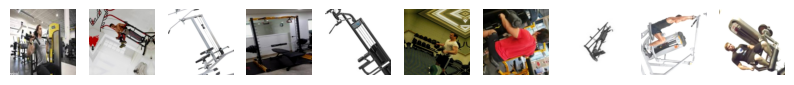

In [8]:
def show_augmented_images(dataset, num_images=10):
    plt.figure(figsize=(10, 10))
    
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0].numpy().astype("uint8"))  # Menampilkan gambar pertama dari batch
        plt.axis('off')  # Menyembunyikan axis
    plt.show()

# Menampilkan gambar dari train_dataset yang telah diaugmentasi
show_augmented_images(train_dataset)

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Modeling

In [23]:
# load Pre-Trained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.summary(show_trainable=True, expand_nested=True)

Model: "mobilenetv2_1.00_224"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                Y          
                                )                                                                            
                                                                                                             
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']          

## Fine Tuning

In [33]:
# Freeze Selected Layer
freeze_to_layer = len(base_model.layers)
for layer in base_model.layers[:freeze_to_layer]:
      layer.trainable = False

In [34]:
def custom_model():
    
    input_layer = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(input_layer, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output_layer = tf.keras.layers.Dense(15, activation=tf.nn.softmax)(x)
    
    # declare inputs and outputs
    cust_model = Model(inputs=input_layer, outputs=output_layer)
    
    return cust_model

In [35]:
model_ft = custom_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model_ft.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_ft.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
75/75 [==============================] - 11s 90ms/step - loss: 2.9354 - accuracy: 0.0780 - val_loss: 2.7046 - val_accuracy: 0.0667
Epoch 2/100
75/75 [==============================] - 7s 81ms/step - loss: 2.7881 - accuracy: 0.1093 - val_loss: 2.6338 - val_accuracy: 0.1200
Epoch 3/100
75/75 [==============================] - 7s 88ms/step - loss: 2.6968 - accuracy: 0.1207 - val_loss: 2.5738 - val_accuracy: 0.1733
Epoch 4/100
75/75 [==============================] - 7s 85ms/step - loss: 2.5830 - accuracy: 0.1700 - val_loss: 2.5171 - val_accuracy: 0.2100
Epoch 5/100
75/75 [==============================] - 7s 82ms/step - loss: 2.5263 - accuracy: 0.1873 - val_loss: 2.4654 - val_accuracy: 0.2533
Epoch 6/100
75/75 [==============================] - 7s 86ms/step - loss: 2.4651 - accuracy: 0.2213 - val_loss: 2.4154 - val_accuracy: 0.2833
Epoch 7/100
75/75 [==============================] - 7s 84ms/step - loss: 2.3403 - accuracy: 0.2527 - val_loss: 2.3650 - val_accuracy: 0.3100
Epoch

In [36]:
model_ft.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 1024)              1311744   
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               5248

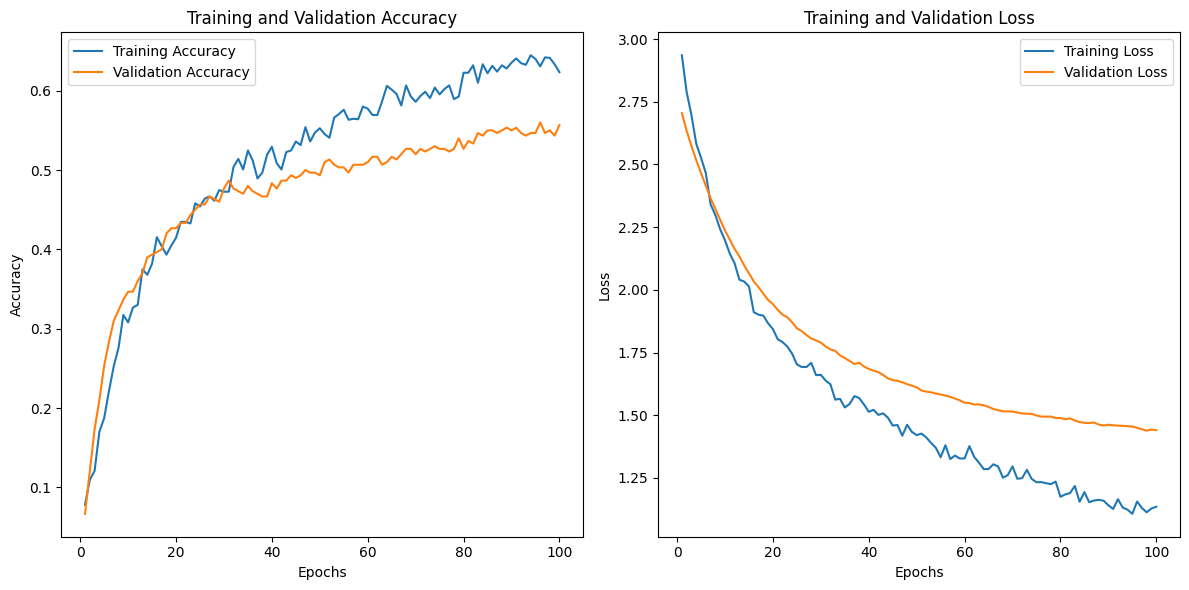

In [37]:
# Extracting data from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Defining the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()